In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D

# import keras
seed=1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings("ignore")


%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

2024-01-09 21:14:01.528669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df=pd.read_csv("/Users/john/git/UTR/data/VEE_3UTR/VEE_3UTR.csv")
plasmid_gate, rna_gate = 20,4
df=df[(df["rna_counts"]>rna_gate)&(df["plasmid_counts"]>plasmid_gate)]
e_train = df.sample(frac=0.8)
e_test= df[~df.index.isin(e_train.index)]
seq_e_train = one_hot_encode(e_train,seq_len=118)
seq_e_test = one_hot_encode(e_test, seq_len=118)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'score'].values.reshape(-1,1))

In [5]:
model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=20,border_mode='same',
                   inp_len=118, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)
e_test = test_data(df=e_test, model=model, obs_col='score',test_seq=seq_e_test)
r = r2(e_test['score'], e_test['pred'])
print('r-squared = ', r)

Epoch 1/20
28/28 [==============================] - 10s 310ms/step - loss: 0.9880
Epoch 2/20
28/28 [==============================] - 9s 301ms/step - loss: 0.7816
Epoch 3/20
28/28 [==============================] - 15s 540ms/step - loss: 0.6132
Epoch 4/20
28/28 [==============================] - 11s 389ms/step - loss: 0.5238
Epoch 5/20
28/28 [==============================] - 10s 364ms/step - loss: 0.5303
Epoch 6/20
28/28 [==============================] - 8s 277ms/step - loss: 0.4744
Epoch 7/20
28/28 [==============================] - 11s 413ms/step - loss: 0.4568
Epoch 8/20
28/28 [==============================] - 11s 375ms/step - loss: 0.4038
Epoch 9/20
28/28 [==============================] - 9s 307ms/step - loss: 0.3735
Epoch 10/20
28/28 [==============================] - 14s 495ms/step - loss: 0.3576
Epoch 11/20
28/28 [==============================] - 12s 415ms/step - loss: 0.3295
Epoch 12/20
28/28 [==============================] - 10s 369ms/step - loss: 0.3135
Epoch 13/20
28/2

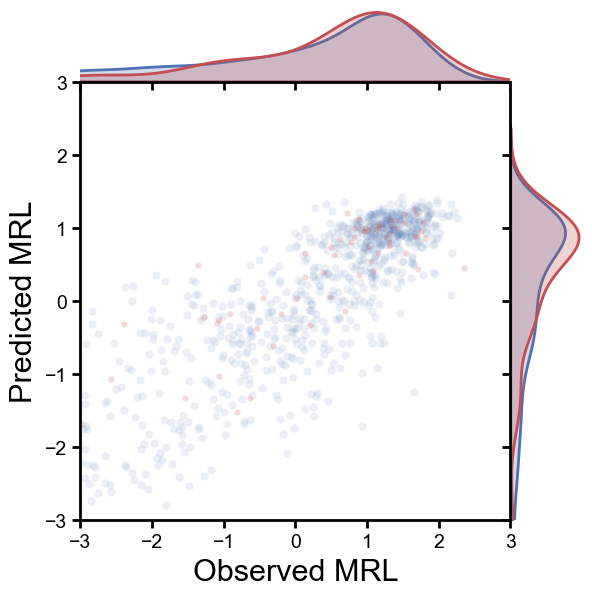

In [6]:
atg = e_test[e_test['seq'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['seq'].apply(lambda x: 'ATG' not in x)]
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='score', y="pred", data=atg, space=0, ratio=6)
g.plot_joint(plt.scatter,color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(-3,3.01, 1));
# ax.set_yticklabels(range(-5,5),size=10);
ax.set_xticks(np.arange(-3,3.01, 1));
# ax.set_xticklabels(range(1,5),size=10);
ax.set_ylim(-3,3)
ax.set_xlim(-3,3)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['score'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig